<div class="alert alert-danger">
<strong><b>NOTE</b> # This notebook needs to be run with the 'Python 3-AXS Spark' kernel on `epyc.astro.washington.edu`</strong>
</div>

## Important concept we need to know about Spark


## Spark Applications
Spark Applications consist of a driver process and a set of executor processes. The driver process runs your main() function, sits on a node in the cluster, and is responsible for three things: maintaining information about the Spark Application; responding to a user’s program or input; and analyzing, distributing, and scheduling work across the executors. The driver process is absolutely essential - it’s the heart of a Spark Application and maintains all relevant information during the lifetime of the application.
The executors are responsible for actually executing the work that the driver assigns them. This means, each executor is responsible for only two things: executing code assigned to it by the driver and reporting the state of the computation, on that executor, back to the driver node.

![title](./sparksession.png)

The cluster manager controls physical machines and allocates resources to Spark Applications.
In this illustration we see on the left, the driver and on the right the four executors on the right. The user can specify how many executors should fall on each node through configurations.

--------------------------------------------------------------------------------------------------------------

### Lazy Evaluation
Lazy evaluation means that Spark will wait until the very last moment to execute the graph of computation instructions. In Spark, instead of modifying the data immediately when we express some operation, we build up a plan of transformations that we would like to apply to our source data. Spark, by waiting until the last minute to execute the code, will compile this plan from your raw, DataFrame transformations, to an efficient physical plan that will run as efficiently as possible across the cluster. This provides immense benefits to the end user because Spark can optimize the entire data flow from end to end.

### Actions
Transformations allow us to build up our logical transformation plan. To trigger the computation, we run an action. An action instructs Spark to compute a result from a series of transformations. The simplest action is count which gives us the total number of records in the DataFrame.

Check out the following link to a PySpark Cheat Sheet that you may find it useful: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf

and also this: http://standarderror.github.io/notes/Data-munging-cheat-sheet/

In [1]:
import axs
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import os
from pyspark.sql.functions import size as spark_size
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import pandas_udf
import pyspark.sql.functions as F

import pandas as pd

import cesium
from cesium.time_series import TimeSeries
from cesium.featurize import featurize_single_ts, featurize_time_series

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
pd.set_option('display.max_columns',120)

### Here is how we start connection to the database via AXS (and the Spark processing engine).

In [4]:
def spark_start(project_path, metastore=None):
    from pyspark.sql import SparkSession

    warehouse_location = os.path.join(project_path, 'spark-warehouse')

    local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[8]")  # <== * note *
            .config('spark.driver.memory', '6G')
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') 
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G") 
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

import getpass
username = getpass.getuser()
print(username)
spark_session = spark_start("/epyc/users/" + username)
#spark_session = spark_start("/epyc/users/zgolkhou")

db = axs.AxsCatalog(spark_session)

# * note *
# Sets the Spark master URL to connect to, such as "local" to run locally, "local[16]" to run locally with 16 cores, 
# or "spark://master:7077" to run on a Spark standalone cluster.

zgolkhou


In [5]:
spark_session
#db.spark
#spark_session.sparkContext._conf.getAll()

### In order to connect to the spark UI, we use ssh tunneling:
$ ssh -L  127.0.0.1:[vwxy]:140.142.4.22:[vwxy] <username>@140.142.4.22

vwxy: Click on the spark UI link from the above cell to find out your specific port number. (it's something like: 4046)
Replace "vwxy" and "username" with the "port number" and your "user_name", respectively. 

Note: we should check out SparkMonitor too. (shared by Colin)
https://krishnan-r.github.io/sparkmonitor/

### The list of availabe datasets in AXS.

In [6]:
db.list_tables()

{'allwise_1am_dup': {'bucket_col': 'zone',
  'dec_col': 'dec',
  'has_lightcurves': False,
  'lc_columns': None,
  'num_buckets': 500,
  'ra_col': 'ra',
  'table_id': 'allwise_1am_dup',
  'table_name': 'allwise_1am_dup',
  'zone_height': 0.0166666666},
 'gaia_dr2_1am_dup': {'bucket_col': 'zone',
  'dec_col': 'dec',
  'has_lightcurves': False,
  'lc_columns': None,
  'num_buckets': 500,
  'ra_col': 'ra',
  'table_id': 'gaia_dr2_1am_dup',
  'table_name': 'gaia_dr2_1am_dup',
  'zone_height': 0.0166666666},
 'gaia_dr2_700lc2': {'bucket_col': 'zone',
  'dec_col': 'dec',
  'has_lightcurves': False,
  'lc_columns': None,
  'num_buckets': 500,
  'ra_col': 'ra',
  'table_id': 'gaia_dr2_700lc2',
  'table_name': 'gaia_dr2_700lc2',
  'zone_height': 0.0166666666},
 'gaia_sdss_3asec': {'bucket_col': 'zone',
  'dec_col': 'dec',
  'has_lightcurves': False,
  'lc_columns': None,
  'num_buckets': 500,
  'ra_col': 'ra',
  'table_id': 'gaia_sdss_3asec',
  'table_name': 'gaia_sdss_3asec',
  'zone_height': 

We can now access the "ZTF matchfiles" light curves table.

In [7]:
%%time

ztf0 = db.load("ztf_1am_lc")
# Petar's comment:  here, we are loading ZTF table with the duplicated rows. (rows in the border regions of the zones are duplicated.)
print("before removing the duplicated rows:",(ztf0.count(), len(ztf0.columns)))

# To remove the duplicated rows:
ztf = ztf0.exclude_duplicates()
print("after removing the duplicated rows:",(ztf.count(), len(ztf.columns)))

before removing the duplicated rows: (3266237701, 94)
after removing the duplicated rows: (2927622797, 94)
CPU times: user 22.2 ms, sys: 4.95 ms, total: 27.2 ms
Wall time: 55.1 s


In [8]:
type(ztf)

axs.axsframe.AxsFrame

In [9]:
ztf.columns

['matchid',
 'ra',
 'dec',
 'zone',
 'dup',
 'astrometricrms',
 'bestastrometricrms',
 'bestchisq',
 'bestcon',
 'bestlineartrend',
 'bestmagrms',
 'bestmaxmag',
 'bestmaxslope',
 'bestmeanmag',
 'bestmedianabsdev',
 'bestmedianmag',
 'bestminmag',
 'bestnmedianbufferrange',
 'bestnpairposslope',
 'bestprobnonqso',
 'bestprobqso',
 'bestskewness',
 'bestsmallkurtosis',
 'beststetsonj',
 'beststetsonk',
 'bestvonneumannratio',
 'bestweightedmagrms',
 'bestweightedmeanmag',
 'chisq',
 'con',
 'lineartrend',
 'magrms',
 'maxmag',
 'maxslope',
 'meanmag',
 'medianabsdev',
 'medianmag',
 'minmag',
 'nbestobs',
 'ngoodobs',
 'nmedianbufferrange',
 'nobs',
 'npairposslope',
 'probnonqso',
 'probqso',
 'refchi',
 'refmag',
 'refmagerr',
 'refsharp',
 'refsnr',
 'skewness',
 'smallkurtosis',
 'stetsonj',
 'stetsonk',
 'uncalibmeanmag',
 'vonneumannratio',
 'weightedmagrms',
 'weightedmeanmag',
 'is_transient',
 'bestnabovemeanbystd',
 'bestnbelowmeanbystd',
 'bestnconsecabovemeanbystd',
 'bestn

In [10]:
%%time

lcsample = ztf.select("ra", "dec", "matchid", "mjd", "psfflux", "nobs").where("nobs > 500").toPandas()
print(len(lcsample))

587135
CPU times: user 11.2 s, sys: 6.15 s, total: 17.3 s
Wall time: 1min 35s


In [11]:
lcsample.head(10)

,ra,dec,matchid,mjd,psfflux,nobs
0,289.845256,51.402956,0007661502201014,"[58295.2908565, 58295.3008796, 58294.3271065, ...","[11215.1845703125, 11518.9140625, 11657.723632...",501
1,289.944470,51.404488,0007661502201031,"[58283.351713, 58291.4785532, 58291.3219213, 5...","[18840.16796875, 18701.822265625, 18462.154296...",501
2,290.030702,51.404670,0007661502201067,"[58277.4032407, 58242.4782407, 58280.3652662, ...","[45493.8046875, 46768.515625, 46297.02734375, ...",501
3,290.096765,51.403599,0007661502201112,"[58305.3647801, 58310.4120949, 58305.4104051, ...","[5861.78271484375, 5420.00341796875, 5639.1689...",501
4,290.173520,51.415174,000766150220937,"[58232.4053009, 58232.4210648, 58230.4513889, ...","[116944.9375, 41147.859375, 77049.8515625, 120...",501
5,290.268699,51.407299,0007661502201108,"[58299.3665509, 58300.3610648, 58280.3652662, ...","[1314.471435546875, 1251.6085205078125, 1314.4...",501
6,290.310661,51.408389,0007661502201105,"[58276.4693171, 58271.3968056, 58280.3286806, ...","[7292.93505859375, 7340.138671875, 7490.489257...",501
7,290.376990,51.405495,00076615022028304,"[58299.3665509, 58298.3233449, 58283.3931597, ...","[43969.40625, 43928.92578125, 45577.6953125, 3...",502
8,290.486307,51.411230,0007661502201118,"[58262.3909375, 58263.3817014, 58263.4301273, ...","[3020.519775390625, 2842.082275390625, 2981.75...",501
9,290.528062,51.414574,0007661502201068,"[58305.3913542, 58310.3954167, 58304.3431597, ...","[923.9663696289062, 898.6494750976562, 925.679...",501


In [12]:
lcsample.loc[lcsample['nobs'].idxmax()]

ra                                                   296.968
dec                                                  48.8488
matchid                                    00076609012020178
mjd        [58267.382581, 58300.3610648, 58307.3898032, 5...
psfflux    [37839.2578125, 43807.69921875, 42261.86328125...
nobs                                                     522
Name: 2824, dtype: object

<IPython.core.display.Javascript object>


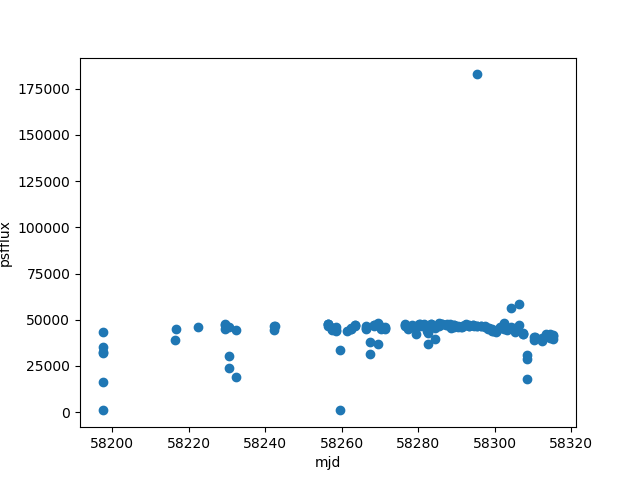

Text(0,0.5,'psfflux')

In [13]:
k = lcsample['nobs'].idxmax()
#
plt.scatter(lcsample.iloc[k].mjd, lcsample.iloc[k].psfflux)
plt.xlabel('mjd'); plt.ylabel('psfflux')

### Working with CESIUM in Apache Spark

cesium is an end-to-end time series analysis framework, consisting of a Python library as well as a web front-end interface, that allows researchers to featurize raw data and apply modern machine learning techniques in a simple, reproducible, and extensible way. Users can apply out-of-the-box feature engineering workflows as well as save and replay their own analyses. Any steps taken in the front end can also be exported to a Jupyter notebook, so users can iterate between possible models within the front end and then fine-tune their analysis using the additional capabilities of the back-end library. The open-source packages make us of many use modern Python toolkits, including xarray, dask, Celery, Flask, and scikit-learn. [source: https://arxiv.org/abs/1609.04504]

You can find the definition for each of the following features at:
http://cesium-ml.org/docs/feature_table.html

In [14]:
features_General = ["amplitude",
                    "flux_percentile_ratio_mid20",
                    "flux_percentile_ratio_mid35",
                    "flux_percentile_ratio_mid50",
                    "flux_percentile_ratio_mid65",
                    "flux_percentile_ratio_mid80",
                    "max_slope",
                    "maximum",
                    "median",
                    "median_absolute_deviation",
                    "minimum",
                    "percent_amplitude",
                    "percent_beyond_1_std",
                    "percent_close_to_median",
                    "percent_difference_flux_percentile",
                    "period_fast",
                    "qso_log_chi2_qsonu",
                    "qso_log_chi2nuNULL_chi2nu",
                    "skew",
                    "std",
                    "stetson_j",
                    "stetson_k",
                    "weighted_average"]

In [15]:
features_Cadence = ["all_times_nhist_numpeaks",
                    "all_times_nhist_peak1_bin",
                    "all_times_nhist_peak2_bin",
                    "all_times_nhist_peak3_bin",
                    "all_times_nhist_peak4_bin",
                    "all_times_nhist_peak_1_to_2",
                    "all_times_nhist_peak_1_to_3",
                    "all_times_nhist_peak_1_to_4",
                    "all_times_nhist_peak_2_to_3",
                    "all_times_nhist_peak_2_to_4",
                    "all_times_nhist_peak_3_to_4",
                    "all_times_nhist_peak_val",
                    "avg_double_to_single_step",
                    "avg_err",
                    "avgt",
                    "cad_probs_1",
                    "cad_probs_10",
                    "cad_probs_20",
                    "cad_probs_30",
                    "cad_probs_40",
                    "cad_probs_50",
                    "cad_probs_100",
                    "cad_probs_500",
                    "cad_probs_1000",
                    "cad_probs_5000",
                    "cad_probs_10000",
                    "cad_probs_50000",
                    "cad_probs_100000",
                    "cad_probs_500000",
                    "cad_probs_1000000",
                    "cad_probs_5000000",
                    "cad_probs_10000000",
                    "cads_avg",
                    "cads_med",
                    "cads_std",
                    "mean",
                    "med_double_to_single_step",
                    "med_err",
                    "n_epochs",
                    "std_double_to_single_step",
                    "std_err",
                    "total_time"]

In [16]:
features_LS =  ["fold2P_slope_10percentile",
                "fold2P_slope_90percentile",
                "freq1_amplitude1",
                "freq1_amplitude2",
                "freq1_amplitude3",
                "freq1_amplitude4",
                "freq1_freq",
                "freq1_lambda",
                "freq1_rel_phase2",
                "freq1_rel_phase3",
                "freq1_rel_phase4",
                "freq1_signif",
                "freq2_amplitude1",
                "freq2_amplitude2",
                "freq2_amplitude3",
                "freq2_amplitude4",
                "freq2_freq",
                "freq2_rel_phase2",
                "freq2_rel_phase3",
                "freq2_rel_phase4",
                "freq3_amplitude1",
                "freq3_amplitude2",
                "freq3_amplitude3",
                "freq3_amplitude4",
                "freq3_freq",
                "freq3_rel_phase2",
                "freq3_rel_phase3",
                "freq3_rel_phase4",
                "freq_amplitude_ratio_21",
                "freq_amplitude_ratio_31",
                "freq_frequency_ratio_21",
                "freq_frequency_ratio_31",
                "freq_model_max_delta_mags",
                "freq_model_min_delta_mags",
                "freq_model_phi1_phi2",
                "freq_n_alias",
                "freq_signif_ratio_21",
                "freq_signif_ratio_31",
                "freq_varrat",
                "freq_y_offset",
                "linear_trend",
                "medperc90_2p_p",
                "p2p_scatter_2praw",
                "p2p_scatter_over_mad",
                "p2p_scatter_pfold_over_mad",
                "p2p_ssqr_diff_over_var",
                "scatter_res_raw"]

In [17]:
print('total number of time-series features in cesium: \
      {}'.format(len(features_Cadence+features_General+features_LS)))

total number of time-series features in cesium:       112


In [18]:
%%time

ztf_sample = (ztf.select("ra", "dec", "matchid", "mjd", "psfflux", "nobs").where("nobs > 500"))

CPU times: user 10.1 ms, sys: 4.52 ms, total: 14.7 ms
Wall time: 63 ms


In [19]:
ztf_sample.show()

+-----------+----------+-----------------+--------------------+--------------------+----+
|         ra|       dec|          matchid|                 mjd|             psfflux|nobs|
+-----------+----------+-----------------+--------------------+--------------------+----+
|289.8452564|51.4029557| 0007661502201014|[58295.2908565, 5...|[11215.1845703125...| 501|
|289.9444698|51.4044884| 0007661502201031|[58283.351713, 58...|[18840.16796875, ...| 501|
|290.0307021|51.4046704| 0007661502201067|[58277.4032407, 5...|[45493.8046875, 4...| 501|
|290.0967646| 51.403599| 0007661502201112|[58305.3647801, 5...|[5861.78271484375...| 501|
|290.1735199|51.4151736|  000766150220937|[58232.4053009, 5...|[116944.9375, 411...| 501|
|290.2686989|51.4072985| 0007661502201108|[58299.3665509, 5...|[1314.47143554687...| 501|
|290.3106606|51.4083888| 0007661502201105|[58276.4693171, 5...|[7292.93505859375...| 501|
|290.3769902|51.4054947|00076615022028304|[58299.3665509, 5...|[43969.40625, 439...| 502|
|290.48630

### Using a regular UDF

This will deserialize one row (i.e., instance, sample, record) at a time, make a prediction with the, and return a prediction, which will be serialized and sent back to Spark to combine with all the other predictions.

### Using a Pandas UDF (i.e., vectorized UDF). 

In this case, Spark will send a tuple of pandas Series objects with multiple rows at a time. The tuple will have one Series per column/feature, in the order they are passed to the UDF. Note that one of these Series objects won't contain features for all rows at once because Spark partitions datasets across workers. The partition size can be tuned, but we'll just use defaults here.

In [20]:
@F.pandas_udf(returnType=ArrayType(DoubleType()))
def featurize_udf_General(mjd, psfflux):
    feat_General_vec = []
    
    for row_mjd, row_psfflux in zip(mjd, psfflux):
            
        feat_General = featurize_time_series(np.array(row_mjd), np.array(row_psfflux),
                                         features_to_use=features_General)
        
        feat_General_vec.append(feat_General.values.flatten())

    return pd.Series(feat_General_vec)

In [21]:
%%time

feature_results_General = ztf_sample.select(
    featurize_udf_General(ztf_sample['mjd'], ztf_sample['psfflux'])).head(1000)

CPU times: user 40.6 ms, sys: 19.9 ms, total: 60.5 ms
Wall time: 1min 24s


In [22]:
type(feature_results_General)

list

In [23]:
ab = [np.array(feature_results_General[0][0])]
for i in np.arange(1,np.shape(feature_results_General)[0]):
    ab = np.concatenate((ab, [np.array(feature_results_General[i][0])]))

In [24]:
pd.DataFrame(ab, columns=features_General)

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,max_slope,maximum,median,median_absolute_deviation,minimum,percent_amplitude,percent_beyond_1_std,percent_close_to_median,percent_difference_flux_percentile,period_fast,qso_log_chi2_qsonu,qso_log_chi2nuNULL_chi2nu,skew,std,stetson_j,stetson_k,weighted_average
0,46701.1,None,None,None,None,None,1.15127e+06,93664.9,11267,241.325,262.67,inf,0.0347222,0.979167,None,1.99852,29.9215,1.4943,9.34437,7576.79,14637.3,0.240897,11685.3
1,75027.6,None,None,None,None,None,1.85003e+06,150517,18284.4,408.087,461.874,inf,0.0347222,0.979167,None,1.99852,30.8729,1.49256,9.31845,12181.3,23767.2,0.243352,18898
2,185207,None,None,None,None,None,4.56464e+06,371530,45577.7,933.051,1115.99,None,0.034965,0.979021,None,1.99835,32.6872,1.47698,9.26538,30174.7,58613,0.242281,47033.9
3,24872.9,None,None,None,None,None,612681,49883.4,6042.84,146.575,137.692,inf,0.034965,0.979021,None,1.99843,28.6708,1.47717,9.29269,4050.33,7986.47,0.24588,6258.61
4,553507,None,None,None,None,None,1.393e+07,1.10968e+06,116945,2284.03,2666.78,None,0.0208333,0.979167,None,1.9986,34.8818,1.4719,9.75984,89478.9,162827,0.226915,121756
5,4964.84,None,None,None,None,None,126397,10389.4,1286.81,39.8663,459.729,inf,0.027972,0.986014,None,1.99852,25.5067,1.51405,9.33886,842.427,1708.52,0.252758,1339.93
6,28802.6,None,None,None,None,None,739227,60140.1,7340.14,147.335,2534.8,None,0.0277778,0.986111,None,1.9986,29.0157,1.48976,9.53911,4826.84,8925.54,0.230498,7631.56
7,178017,None,None,None,None,None,4.38449e+06,357103,44253.8,781.332,1068.49,None,0.0344828,0.97931,None,1.99843,32.6025,1.47872,9.28978,28820.9,56081.4,0.242729,45616.9
8,10736.3,None,None,None,None,None,274523,22423.5,2799.14,71.3914,950.873,None,0.0277778,0.986111,None,1.99852,27.0479,1.49671,9.36736,1810.81,3495.16,0.240522,2918.67
9,3860.71,0,0,0,0,0,98360.8,8108.35,988.573,38.5805,386.922,inf,0.0138889,0.986111,inf,1.9986,24.9946,1.50793,9.48151,652.285,1344.67,0.256794,1034.76


In [25]:
@F.pandas_udf(returnType=ArrayType(DoubleType()))
def featurize_udf_General_LS(mjd, psfflux):
    feat_General_LS_vec = []
    
    for row_mjd, row_psfflux in zip(mjd, psfflux):
            
        feat_General_LS = featurize_time_series(np.array(row_mjd), np.array(row_psfflux),
                                         features_to_use=features_General+
                                                         features_LS)
         
        feat_General_LS_vec.append(feat_General_LS.values.flatten())

    return pd.Series(feat_General_LS_vec)

In [26]:
%%time

feature_results_General_LS = ztf_sample.select(
    featurize_udf_General_LS(ztf_sample['mjd'], ztf_sample['psfflux'])).head(1000)

CPU times: user 59.4 ms, sys: 19.1 ms, total: 78.6 ms
Wall time: 5min 2s


In [27]:
ac = [np.array(feature_results_General_LS[0][0])]
for i in np.arange(1,np.shape(feature_results_General_LS)[0]):
    ac = np.concatenate((ac, [np.array(feature_results_General_LS[i][0])]))

In [28]:
pd.DataFrame(ac, columns=features_General+features_LS)

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,max_slope,maximum,median,median_absolute_deviation,minimum,percent_amplitude,percent_beyond_1_std,percent_close_to_median,percent_difference_flux_percentile,period_fast,qso_log_chi2_qsonu,qso_log_chi2nuNULL_chi2nu,skew,std,stetson_j,stetson_k,weighted_average,fold2P_slope_10percentile,fold2P_slope_90percentile,freq1_amplitude1,freq1_amplitude2,freq1_amplitude3,freq1_amplitude4,freq1_freq,freq1_lambda,freq1_rel_phase2,freq1_rel_phase3,freq1_rel_phase4,freq1_signif,freq2_amplitude1,freq2_amplitude2,freq2_amplitude3,freq2_amplitude4,freq2_freq,freq2_rel_phase2,freq2_rel_phase3,freq2_rel_phase4,freq3_amplitude1,freq3_amplitude2,freq3_amplitude3,freq3_amplitude4,freq3_freq,freq3_rel_phase2,freq3_rel_phase3,freq3_rel_phase4,freq_amplitude_ratio_21,freq_amplitude_ratio_31,freq_frequency_ratio_21,freq_frequency_ratio_31,freq_model_max_delta_mags,freq_model_min_delta_mags,freq_model_phi1_phi2,freq_n_alias,freq_signif_ratio_21,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw
0,46701.1,None,None,None,None,None,1.15127e+06,93664.9,11267,241.325,262.67,inf,0.0347222,0.979167,None,1.99852,29.9215,1.4943,9.34437,7576.79,14637.3,0.240897,11685.3,-113900,112494,81196.2,48296.8,15892.4,6608.05,3.00235,0.00694444,-1.60403,2.84085,-0.568357,8.81464,1101.98,107.375,10.2362,9.96372,6.09924,1.41979,0.995439,1.41247,925.723,59.0074,13.6589,9.4115,1.10074,-0.414462,2.53654,0.583544,0.0135718,0.0114011,2.03149,0.366625,4278.38,182388,0.0550836,1,0.413098,0.357515,0.0364037,46658.1,3.53604,1.25693,1.0265,0.846465,1.50785,1.2966,2.93216
1,75027.6,None,None,None,None,None,1.85003e+06,150517,18284.4,408.087,461.874,inf,0.0347222,0.979167,None,1.99852,30.8729,1.49256,9.31845,12181.3,23767.2,0.243352,18898,-183512,180348,130296,77415,25414.2,10585.4,3.00235,0.00694444,-1.60464,2.84196,-0.57057,8.80445,1769.67,170.375,14.9768,16.0549,6.09924,1.46667,1.05956,1.38312,1539.15,93.6702,23.0438,15.0992,1.10074,-0.356492,2.52467,0.569158,0.0135819,0.0118127,2.03149,0.366625,6537.5,292593,0.0545201,1,0.409621,0.370046,0.0365585,74897.4,5.84063,1.20739,1.02433,0.716764,1.60698,1.29479,2.94081
2,185207,None,None,None,None,None,4.56464e+06,371530,45577.7,933.051,1115.99,None,0.034965,0.979021,None,1.99835,32.6872,1.47698,9.26538,30174.7,58613,0.242281,47033.9,-444684,446400,322218,191245,62677.4,26130,3.00235,0.00699301,-1.60412,2.84281,-0.583591,8.764,4406.14,467.026,29.4838,40.2937,6.09924,1.47497,0.885241,1.31926,3755.97,197.03,32.1159,34.5819,1.10157,-0.803984,2.61448,0.94446,0.0136744,0.0116566,2.03149,0.366902,16259.3,723300,0.0546649,1,0.411178,0.370095,0.0365379,185203,13.8214,1.28453,1.02264,0.909487,1.75089,1.29417,3.16626
3,24872.9,None,None,None,None,None,612681,49883.4,6042.84,146.575,137.692,inf,0.034965,0.979021,None,1.99843,28.6708,1.47717,9.29269,4050.33,7986.47,0.24588,6258.61,-62368.6,60070.6,43232,25668.2,8419.18,3506.46,3.00235,0.00699301,-1.60434,2.8425,-0.578273,8.7785,576.876,57.8842,4.92715,5.1501,6.09924,1.40318,0.822538,1.40436,505.425,32.4492,7.46221,5.2225,1.10074,-0.359753,2.38411,0.622136,0.0133437,0.011691,2.03149,0.366625,2200.94,97057.2,0.0546861,1,0.402753,0.367383,0.0364463,24848.3,1.58518,1.28903,1.02326,0.973608,1.51252,1.29663,2.72919
4,553507,None,None,None,None,None,1.393e+07,1.10968e+06,116945,2284.03,2666.78,None,0.0208333,0.979167,None,1.9986,34.8818,1.4719,9.75984,89478.9,162827,0.226915,121756,-1.30419e+06,1.34583e+06,952416,570538,194454,79273.8,3.00235,0.00694444,-1.60879,2.82659,-0.474748,8.94857,11563.4,1204.31,118.579,107.177,6.09924,1.34724,1.05453,1.39634,10335.1,628.067,140.702,100.827,1.10074,-0.262933,2.50447,0.579644,0.0121411,0.0108515,2.03149,0.366625,51302.3,2.15361e+06,0.0550059,1,0.389379,0.361223,0.0366615,546388,29.7427,1.25113,1.

In [29]:
@F.pandas_udf(returnType=ArrayType(DoubleType()))
def featurize_udf_General_LS_Cadence(mjd, psfflux):
    feat_General_LS_Cadence_vec = []
    
    for row_mjd, row_psfflux in zip(mjd, psfflux):
        
        feat_General_LS_Cadence = featurize_time_series(np.array(row_mjd), np.array(row_psfflux),
                                         features_to_use=features_General+
                                                         features_LS+
                                                         features_Cadence)
        
        feat_General_LS_Cadence_vec.append(feat_General_LS_Cadence.values.flatten())

    return pd.Series(feat_General_LS_Cadence_vec)

In [30]:
%%time

feature_results_General_LS_Cadence = ztf_sample.select(
    featurize_udf_General_LS_Cadence(ztf_sample['mjd'], ztf_sample['psfflux'])).head(1000)

CPU times: user 83 ms, sys: 21.6 ms, total: 105 ms
Wall time: 7min 25s


In [31]:
ad = [np.array(feature_results_General_LS_Cadence[0][0])]
for i in np.arange(1,np.shape(feature_results_General_LS_Cadence)[0]):
    ad = np.concatenate((ad, [np.array(feature_results_General_LS_Cadence[i][0])]))

In [32]:
pd.DataFrame(ad, columns=features_General+features_LS+features_Cadence)

,amplitude,flux_percentile_ratio_mid20,flux_percentile_ratio_mid35,flux_percentile_ratio_mid50,flux_percentile_ratio_mid65,flux_percentile_ratio_mid80,max_slope,maximum,median,median_absolute_deviation,minimum,percent_amplitude,percent_beyond_1_std,percent_close_to_median,percent_difference_flux_percentile,period_fast,qso_log_chi2_qsonu,qso_log_chi2nuNULL_chi2nu,skew,std,stetson_j,stetson_k,weighted_average,fold2P_slope_10percentile,fold2P_slope_90percentile,freq1_amplitude1,freq1_amplitude2,freq1_amplitude3,freq1_amplitude4,freq1_freq,freq1_lambda,freq1_rel_phase2,freq1_rel_phase3,freq1_rel_phase4,freq1_signif,freq2_amplitude1,freq2_amplitude2,freq2_amplitude3,freq2_amplitude4,freq2_freq,freq2_rel_phase2,freq2_rel_phase3,freq2_rel_phase4,freq3_amplitude1,freq3_amplitude2,freq3_amplitude3,freq3_amplitude4,freq3_freq,freq3_rel_phase2,freq3_rel_phase3,freq3_rel_phase4,freq_amplitude_ratio_21,freq_amplitude_ratio_31,freq_frequency_ratio_21,freq_frequency_ratio_31,freq_model_max_delta_mags,freq_model_min_delta_mags,freq_model_phi1_phi2,freq_n_alias,freq_signif_ratio_21,freq_signif_ratio_31,freq_varrat,freq_y_offset,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,all_times_nhist_peak_3_to_4,all_times_nhist_peak_val,avg_double_to_single_step,avg_err,avgt,cad_probs_1,cad_probs_10,cad_probs_20,cad_probs_30,cad_probs_40,cad_probs_50,cad_probs_100,cad_probs_500,cad_probs_1000,cad_probs_5000,cad_probs_10000,cad_probs_50000,cad_probs_100000,cad_probs_500000,cad_probs_1000000,cad_probs_5000000,cad_probs_10000000,cads_avg,cads_med,cads_std,mean,med_double_to_single_step,med_err,n_epochs,std_double_to_single_step,std_err,total_time
0,46701.1,None,None,None,None,None,1.15127e+06,93664.9,11267,241.325,262.67,inf,0.0347222,0.979167,None,1.99852,29.9215,1.4943,9.34437,7576.79,14637.3,0.240897,11685.3,-113900,112494,81196.2,48296.8,15892.4,6608.05,3.00235,0.00694444,-1.60403,2.84085,-0.568357,8.81464,1101.98,107.375,10.2362,9.96372,6.09924,1.41979,0.995439,1.41247,925.723,59.0074,13.6589,9.4115,1.10074,-0.414462,2.53654,0.583544,0.0135718,0.0114011,2.03149,0.366625,4278.38,182388,0.0550836,1,0.413098,0.357515,0.0364037,46658.1,3.53604,1.25693,1.0265,0.846465,1.50785,1.2966,2.93216,12,6,10,14,19,1.27143,1.42021,2.06178,1.11702,1.62162,1.45174,0.0273252,-9.33943,0.0001,58279.3,0,0,0.104895,0.244755,0.412587,0.517483,0.545455,0.65035,0.65035,0.972028,0.979021,1,1,1,1,1,1,0.671642,0.0326157,1.84161,11685.3,-1.00852,0.0001,144,306.083,1.35525e-20,96.0448
1,75027.6,None,None,None,None,None,1.85003e+06,150517,18284.4,408.087,461.874,inf,0.0347222,0.979167,None,1.99852,30.8729,1.49256,9.31845,12181.3,23767.2,0.243352,18898,-183512,180348,130296,77415,25414.2,10585.4,3.00235,0.00694444,-1.60464,2.84196,-0.57057,8.80445,1769.67,170.375,14.9768,16.0549,6.09924,1.46667,1.05956,1.38312,1539.15,93.6702,23.0438,15.0992,1.10074,-0.356492,2.52467,0.569158,0.0135819,0.0118127,2.03149,0.366625,6537.5,292593,0.0545201,1,0.409621,0.370046,0.0365585,74897.4,5.84063,1.20739,1.02433,0.716764,1.60698,1.29479,2.94081,12,6,10,14,19,1.27143,1.42021,2.06178,1.11702,1.62162,1.45174,0.0273252,-9.33943,0.0001,58279.3,0,0,0.104895,0.244755,0.412587,0.517483,0.545455,0.65035,0.65035,0.972028,0.979021,1,1,1,1,1,1,0.671642,0.0326157,1.84161,18898,-1.00852,0.0001,144,306.083,1.35525e-20,96.0448
2,185207,None,None,None,None,None,4.56464e+06,371530,45577.7,933.051,1115.99,None,0.034965,0.979021,None,1.99835,32.6872,1.47698,9.26538,30174.7,58613,0.242281,47033.9,-444684,446400,322218,191245,62677.4,26130,3.00235,0.00699301,-1.60412,2.84281,-0.583591,8.764,4406.14,467.026,29.4838,40.2937,6.09924,1.47497,0.885241,1.31926,3755.97,197.03,32.1